In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def get_df(filename, train=True):
    '''
    read data and pre-process into dataframe
    '''
    # read train data
    X = pd.read_csv(filename)

    # select numeric columns and fill NA values
    numeric_columns = X.select_dtypes(include=['number']).columns
    X[numeric_columns] = X[numeric_columns].fillna(method="ffill")

    ids, Y = X["Id"], []
    if train:
        Y = X["SalePrice"]
        X = X.drop(["Id", "SalePrice"], axis=1)
    else:
        X = X.drop(["Id"], axis=1)

    # encode categorical data
    to_encode = []
    for name, values in X.iteritems():
        try:
            c = float(values[0])
            if np.isnan(c):
                raise Exception
        except:
            to_encode.append(name)

    label_encode = X[to_encode].apply(LabelEncoder().fit_transform)
    X = pd.concat([X, label_encode], axis=1)

    # drop encoded columns
    X = X.drop(label_encode, axis=1)

    return X, Y, ids


<AxesSubplot:>

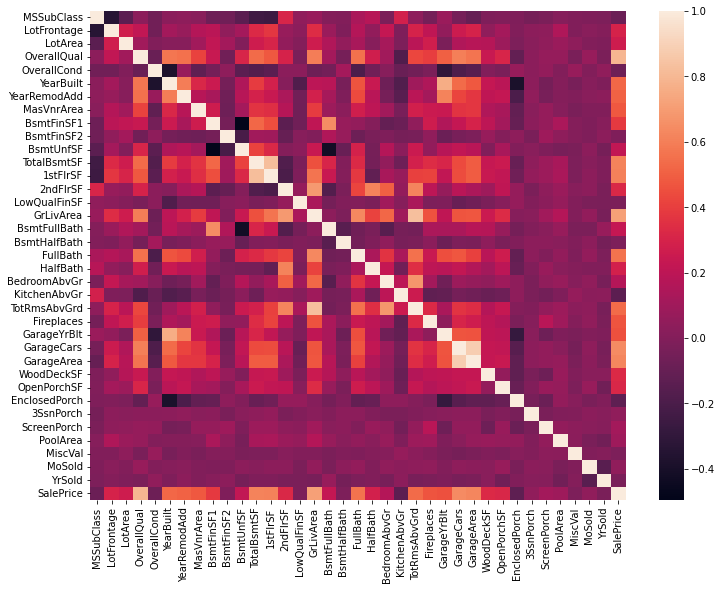

In [13]:
X_train, Y_train, _ = get_df("data/train.csv")

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap((pd.concat([X_train, Y_train], axis=1).corr()))


In [4]:
D_train = xgb.DMatrix(X_train, label=Y_train)

model = xgb.XGBRegressor()
model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [5]:
# predicting test set and create submission file
with open("submission.txt", 'w') as outfile:
    outfile.write("Id,SalePrice\n")

    X_test, _, ids = get_df("data/test.csv", train=False)

    preds = model.predict(X_test)
    for pred, id in zip(preds, ids):
        outfile.write(str(id) + ',' + str(pred) + '\n')
